In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box
import pySaliencyMap

## construct the tiny-yolo model ##

In [52]:
keras.backend.set_image_dim_ordering('th')

In [53]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [54]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_19 (Convolution2D) (None, 16, 448, 448)  448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
leakyrelu_21 (LeakyReLU)         (None, 16, 448, 448)  0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 16, 224, 224)  0           leakyrelu_21[0][0]               
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 32, 224, 224)  4640        maxpooling2d_13[0][0]            
___________________________________________________________________________________________

## load weight from pretrained weights for yolo ##
The weight file can be downloaded from https://pjreddie.com/darknet/yolo/

In [55]:
load_weights(model,'./yolo-tiny.weights')

In [56]:
def get_box(boxes,im,crop_dim):
    fin=[]
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        fin.append([left,top,right,bot,b.prob])

    return fin

In [57]:
def get_nulled_image(image,dimen):
    final=np.array(np.zeros(shape=(image.shape[0],image.shape[1])))
    for d in dimen:
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if i>d[1] and i<d[3] and j>d[0] and j<d[2]:
                        final[i][j]=d[4]
    return final

In [58]:
def get_final_image(image,final,dimen,th):
    sm = pySaliencyMap.pySaliencyMap(image.shape[1], image.shape[0])
    sailency_map=sm.SMGetSM(image)
    
    
#     multiplication of the matrices
    im=image
    thresh=0.03
 

    for d in dimen:
        threshold=d[4]-th
        j=d[0]
        while(j<d[2]):
            i=d[1]
            while(i<d[3]):
                num=final[i][j]*sailency_map[i][j]
                if(num>=threshold):
                    im[i][j][:]=0
                i=i+1
            j=j+1
    return im

In [59]:
def frame_func(image,th=0.4):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    dimen=get_box(boxes,image,[[500,1280],[300,650]])
    if len(dimen)==0:
        return image
    else :
        final=get_nulled_image(image,dimen)
        
        return get_final_image(image,final,dimen,th)

In [173]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./kkk.mp4")

In [174]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4





  0%|          | 0/192 [00:00<?, ?it/s]


  1%|          | 1/192 [00:02<08:12,  2.58s/it]


  1%|          | 2/192 [00:04<07:59,  2.52s/it]


  2%|▏         | 3/192 [00:07<07:33,  2.40s/it]


  2%|▏         | 4/192 [00:09<07:10,  2.29s/it]


  3%|▎         | 5/192 [00:11<06:53,  2.21s/it]


  3%|▎         | 6/192 [00:13<06:42,  2.16s/it]


  4%|▎         | 7/192 [00:15<06:38,  2.16s/it]


  4%|▍         | 8/192 [00:17<06:30,  2.12s/it]


  5%|▍         | 9/192 [00:19<06:23,  2.09s/it]


  5%|▌         | 10/192 [00:21<06:18,  2.08s/it]


  6%|▌         | 11/192 [00:23<06:13,  2.06s/it]


  6%|▋         | 12/192 [00:25<06:15,  2.09s/it]


  7%|▋         | 13/192 [00:27<06:11,  2.08s/it]


  7%|▋         | 14/192 [00:29<06:09,  2.08s/it]


  8%|▊         | 15/192 [00:31<06:05,  2.06s/it]


  8%|▊         | 16/192 [00:33<06:00,  2.05s/it]


  9%|▉         | 17/192 [00:35<06:01,  2.06s/it]


  9%|▉         | 18/192 [00:37<05:56,  2.05s/it]


 10%|▉         | 19/192 [00:40<05:58,  2.07s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 18min 33s, sys: 1min 16s, total: 19min 49s
Wall time: 7min 9s


In [60]:
img=(cv2.imread("test_images/test4.jpg"))
detected=frame_func(img,0.4)


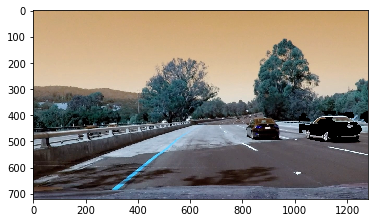

In [62]:
plt.imshow(detected,cmap='gray')